# pySCENIC protocol: sunhye 2nd experiment

June 2020

Dataset: 2nd experiment from SHL

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [58]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

#### set variables for file paths to read from and write to:

In [59]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj'

In [60]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
loom_file = 'output/scenic/allfeatures_pt1_seu-final.loom'

adata_file = loom_file.replace("-final.loom", ".h5ad")
# adata_file = 'output/scenic/allfeatures_only_pt_w_ctrl_seu.h5ad'



In [61]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

## Extract relevant data from the integrated loom file

In [62]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [63]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [64]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [65]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [66]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [67]:
regulons.keys()

dict_keys(['CREBL2_(+)', 'E2F1_(+)', 'E2F3_(+)', 'ESRRG_(+)', 'FOXO1_(+)', 'HSF1_(+)', 'LHX3_(+)', 'LHX4_(+)', 'MAZ_(+)', 'PRDM1_(+)', 'RORA_(+)', 'SMAD9_(+)'])

In [68]:
myregulon = 'LHX3_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 16 genes in LHX3_(+).'

## distribution of number of genes per regulon

In [69]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count    12.000000
mean     15.416667
std       9.326973
min       5.000000
25%       8.000000
50%      13.500000
75%      19.250000
max      36.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [70]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [71]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [72]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [73]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Regulons' as categorical


In [74]:
adata_h5ad = sc.read(adata_file)

metadata = adata_h5ad.obs

new_adata_obs = adata.obs.join(metadata, how = "left")

In [75]:
adata.obs = new_adata_obs
adata.obs.columns

Index(['ClusterID', 'Clusterings', 'Louvain_clusters_Scanpy', 'Percent_mito',
       'nGene', 'nUMI', 'nCount_RNA', 'nFeature_RNA', 'day', 'treatment_group',
       'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane',
       'custom_cluster', 'sample_number', 'sample_id', 'names',
       'gene_snn_res.0.2', 'seurat_clusters', 'gene_snn_res.0.4',
       'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1',
       'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6',
       'gene_snn_res.1.8', 'gene_snn_res.2', 'read_count', 'S.Score',
       'G2M.Score', 'Phase', 'percent.mt', 'pt1_clusters', 'pt2_clusters',
       'shCtrl_PC123', 'nCount_gene', 'nFeature_gene', 'nCount_transcript',
       'nFeature_transcript', 'transcript_snn_res.0.2',
       'transcript_snn_res.0.4', 'transcript_snn_res.0.6',
       'transcript_snn_res.0.8', 'transcript_snn_res.1',
       'transcript_snn_res.1.2', 'transcript_snn_res.1.4',
       'transcript_snn_res.1.6', 'transcript_snn_res.1.8',
      

In [76]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [77]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [78]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [79]:
# df_motifs = load_motifs('reg.csv')

In [80]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [81]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [82]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


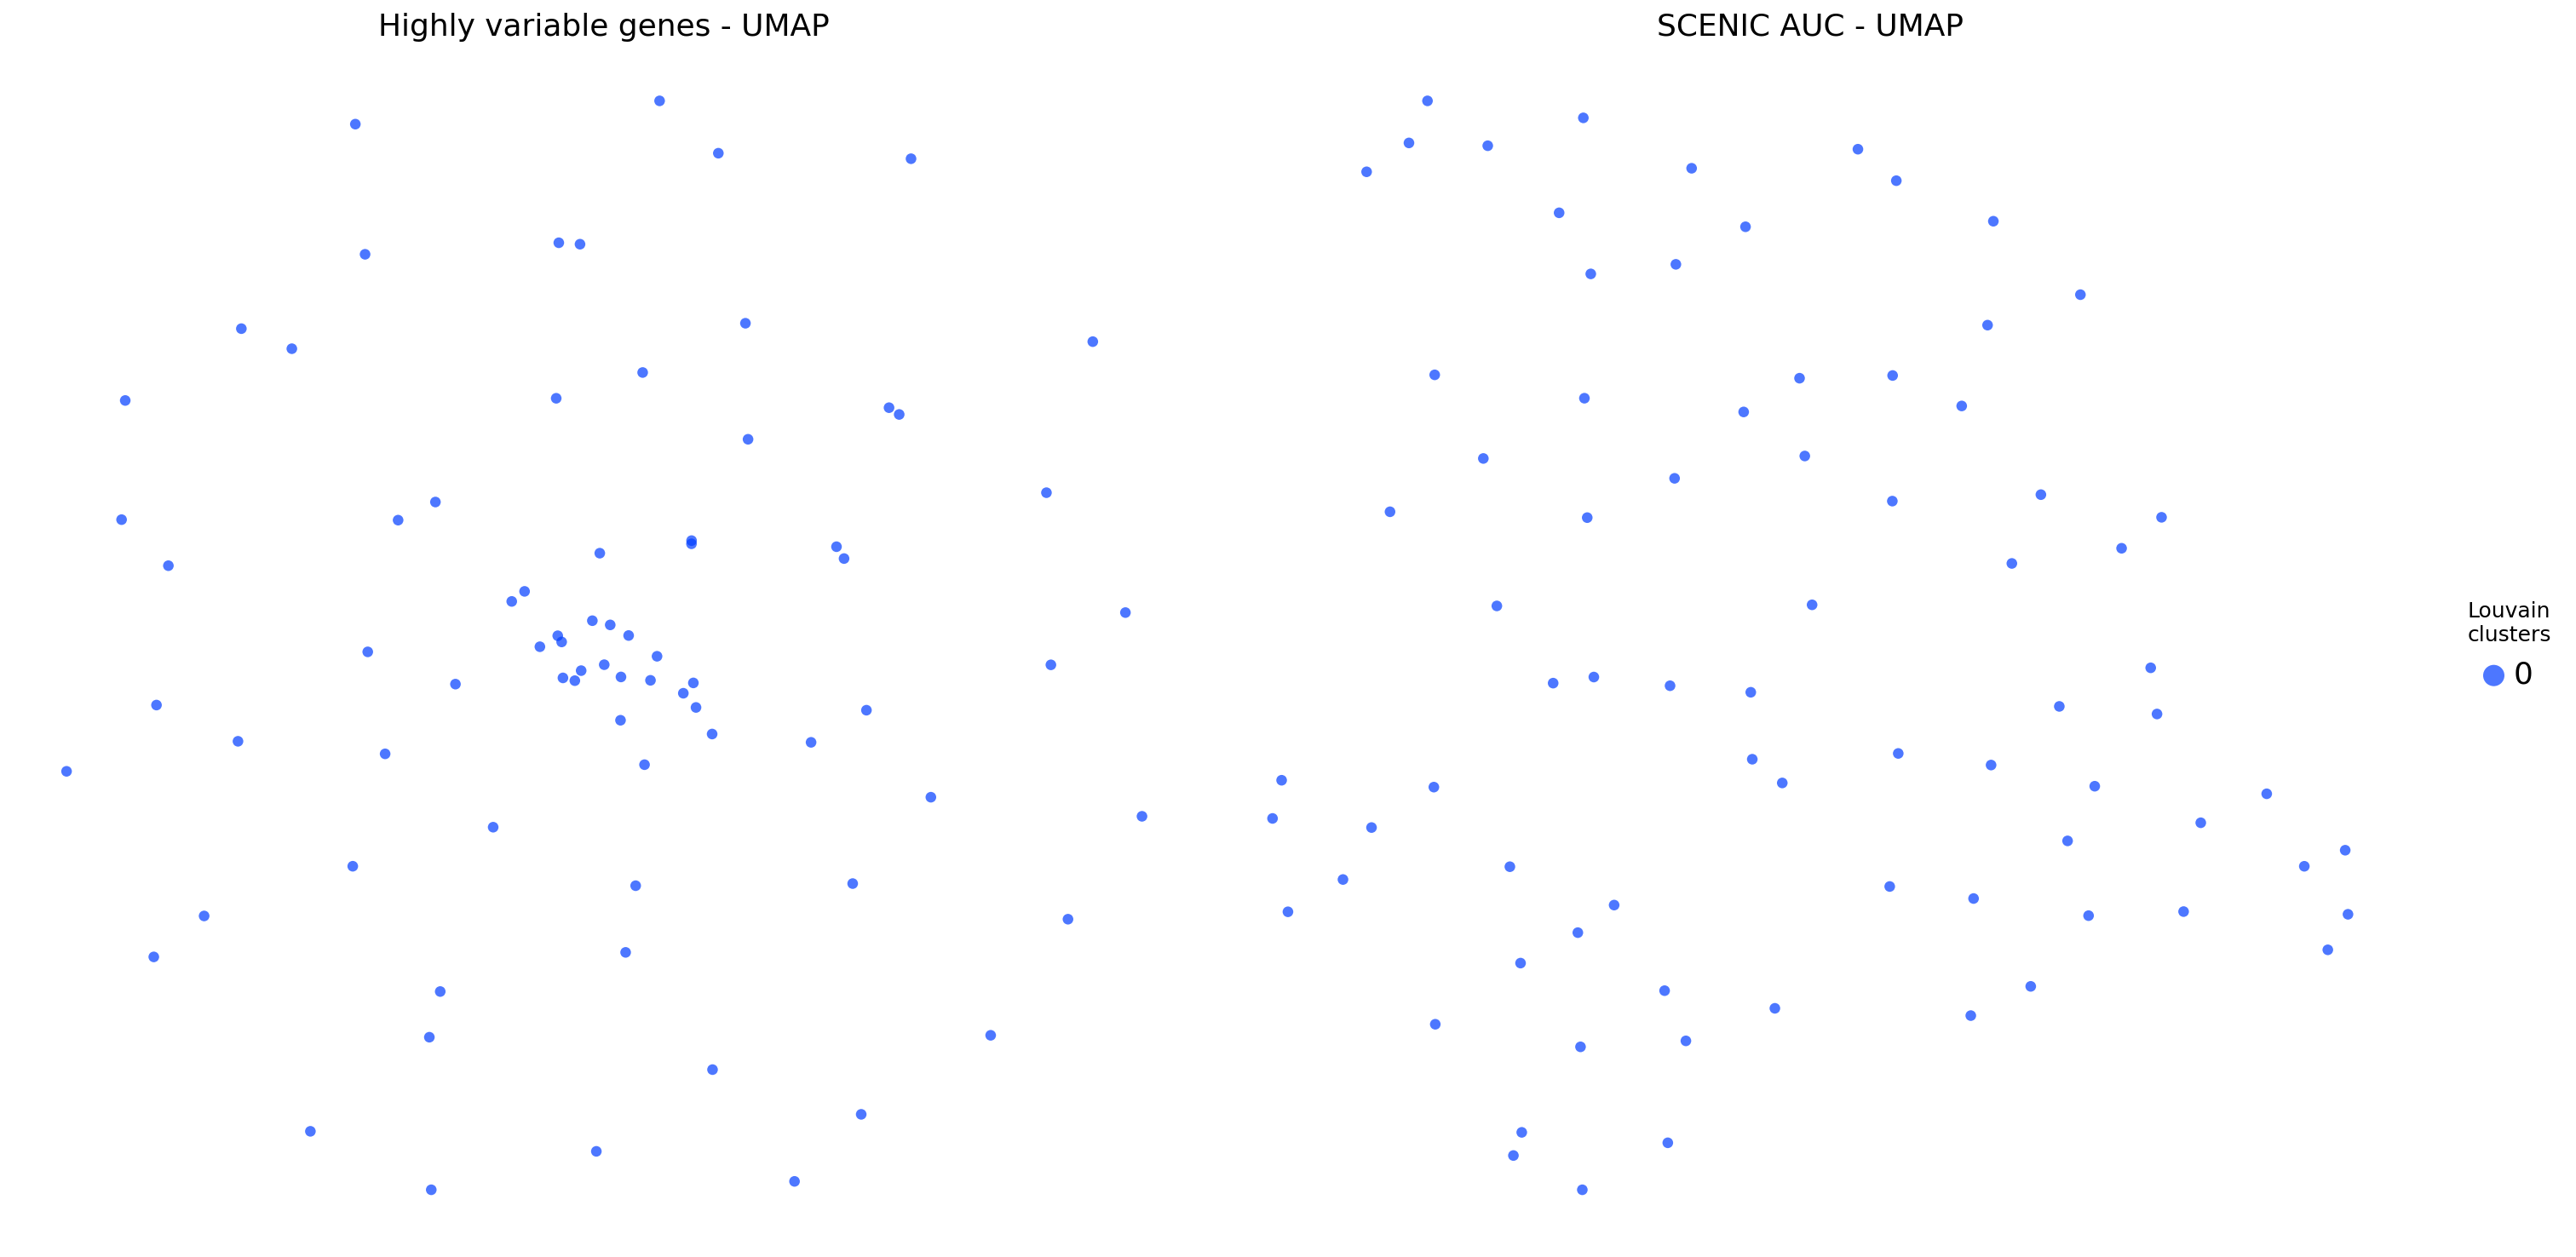

In [83]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [84]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [85]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [86]:
metavar="pt1_clusters"

### Calculate RSS

In [87]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] ).sort_index()
rss_louvain

CREBL2_(+)  E2F1_(+)  E2F3_(+)  ESRRG_(+)  FOXO1_(+)  HSF1_(+)  LHX3_(+)  \
0     0.243124  0.192909  0.179942   0.167445   0.168709  0.213570  0.224768   
1a    0.309121  0.216333  0.211552   0.167445   0.242043  0.309952  0.288826   
1b    0.278371  0.267301  0.248438   0.167445   0.193462  0.278223  0.264974   
1c    0.248117  0.252061  0.193517   0.167445   0.324662  0.226256  0.269470   
1d    0.298462  0.251854  0.301132   0.225867   0.269071  0.403848  0.358108   
1e    0.401388  0.309342  0.397989   0.299219   0.274926  0.377540  0.394271   

    LHX4_(+)   MAZ_(+)  PRDM1_(+)  RORA_(+)  SMAD9_(+)  
0   0.238699  0.232096   0.205934  0.218565   0.167445  
1a  0.274636  0.300052   0.268309  0.320383   0.167445  
1b  0.301277  0.310565   0.264055  0.259939   0.204938  
1c  0.297479  0.291813   0.270030  0.315048   0.232974  
1d  0.387056  0.360991   0.357294  0.321287   0.257458  
1e  0.426920  0.413081   0.423251  0.392634   0.167445

In [38]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

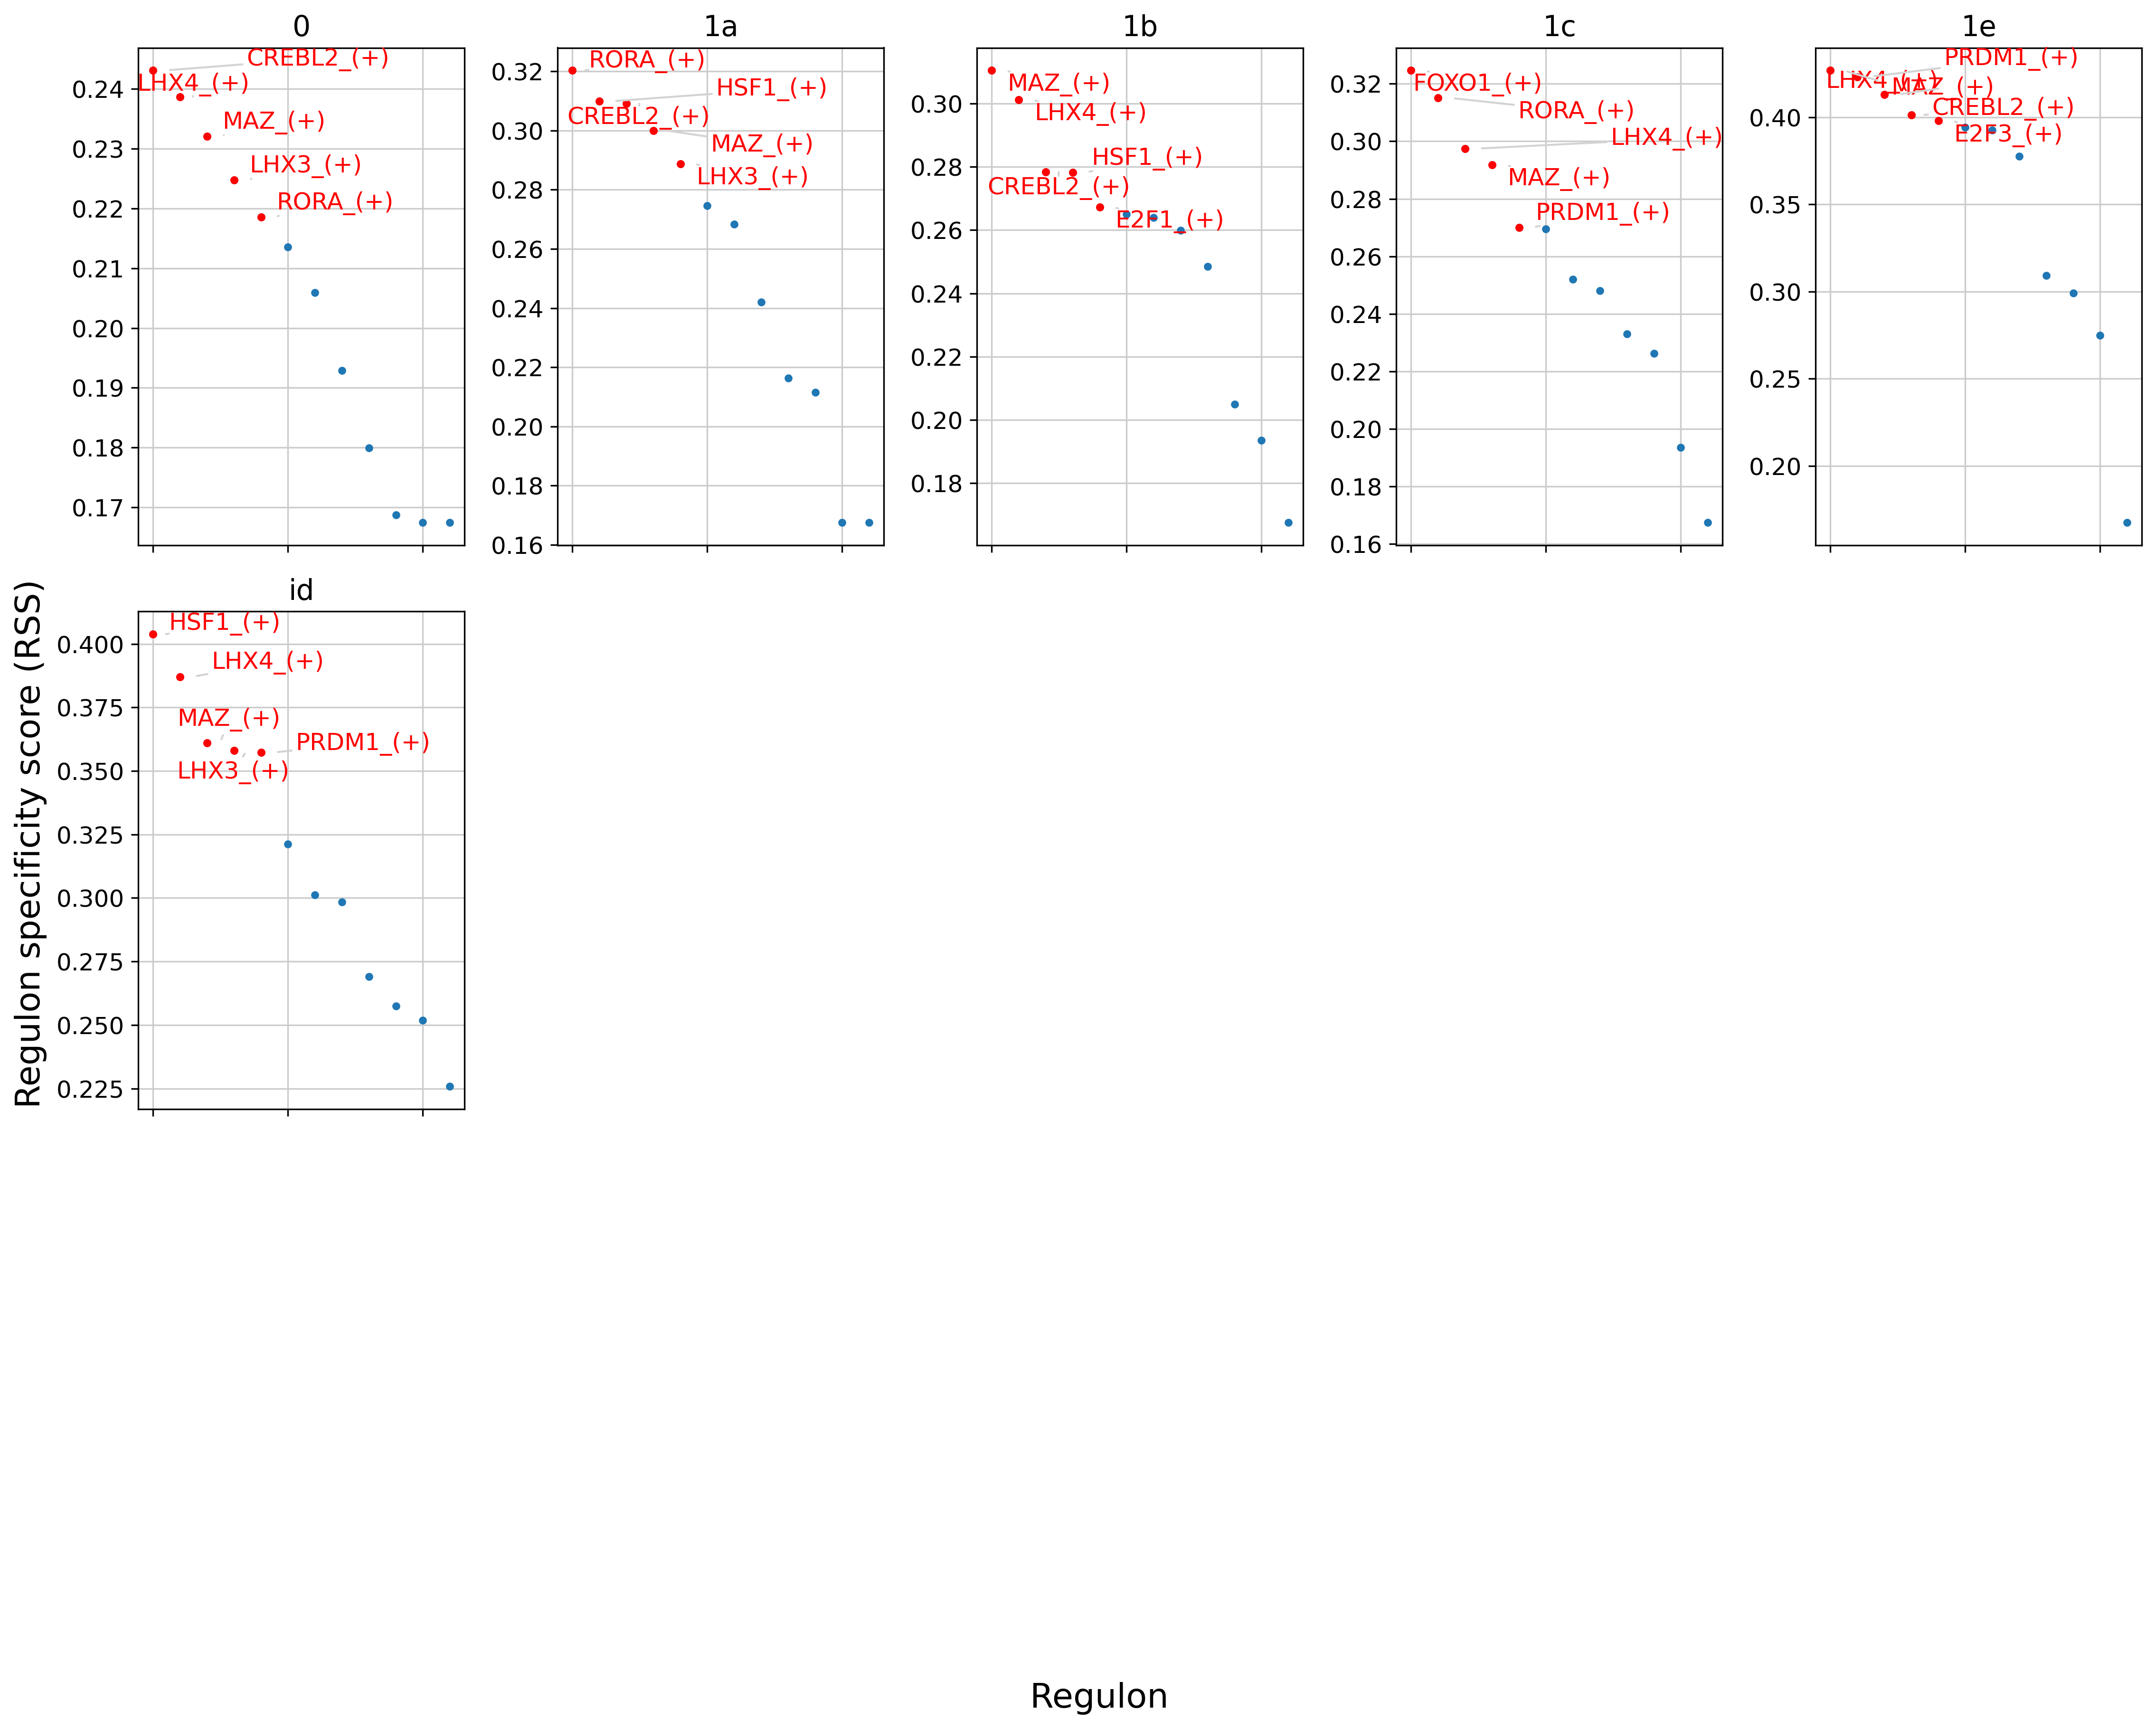

In [39]:
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [40]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [41]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

E2F1_(+)  LHX4_(+)  HSF1_(+)  CREBL2_(+)  LHX3_(+)  E2F3_(+)  \
pt1_clusters                                                                 
0             0.002610  0.174212  0.025687    0.081170  0.056210  0.001357   
1a            0.005471  0.146726  0.050364    0.093493  0.077399  0.006063   
1b            0.006447  0.157940  0.033052    0.064073  0.046074  0.005350   
1c            0.007882  0.151519  0.015190    0.045522  0.056205  0.002174   
1e            0.006792  0.150974  0.031833    0.067605  0.059181  0.010644   
id            0.006783  0.151501  0.043009    0.051353  0.056523  0.008303   

               MAZ_(+)  RORA_(+)  PRDM1_(+)  FOXO1_(+)  
pt1_clusters                                            
0             0.151448  0.076132   0.048227   0.000071  
1a            0.192098  0.125667   0.086626   0.007555  
1b            0.170596  0.058650   0.064804   0.001831  
1c            0.149813  0.105214   0.071968   0.012811  
1e            0.141680  0.080760   0.100667   0.005607  
id            0.131102  0.061128   0.081745   0.006503

#### Generate a Z-score for each regulon to enable comparison between regulons

In [42]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [43]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [44]:
cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['shl20171031-071', 'shl20171031-046', 'shl20171031-078',
       'shl20171031-057', 'shl20171031-041', 'shl20171031-068',
       'shl20171031-062', 'shl20171031-059', 'shl20171031-052',
       'shl20171031-049', 'shl20171031-048', 'shl20171031-079',
       'shl20171031-173', 'shl20171031-156', 'shl20171031-416',
       'shl20171031-250', 'shl20171031-234', 'shl20171031-070',
       'shl20171031-063', 'shl20171031-061', 'shl20171031-053',
       'shl20171031-419', 'shl20171031-350', 'shl20171031-349',
       'shl20171031-331', 'shl20171031-330', 'shl20171031-318',
       'shl20171031-262', 'shl20171031-263', 'shl20171031-045',
       'shl20171031-133', 'shl20171031-268', 'shl20171031-455',
       'shl20171031-510', 'shl20171031-516', 'shl20171031-518',
       'shl20171031-523', 'shl20171031-527', 'shl20171031-531',
       'shl20171031-534', 'shl20171031-538', 'shl20171031-539',
       'shl20171031-540', 'shl20171031-548', 'shl20171031-547',
       'shl20171031-541', 'shl20171031-5

In [45]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [46]:
cats

['0', '1a', '1b', '1c', '1e', 'id']

In [47]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

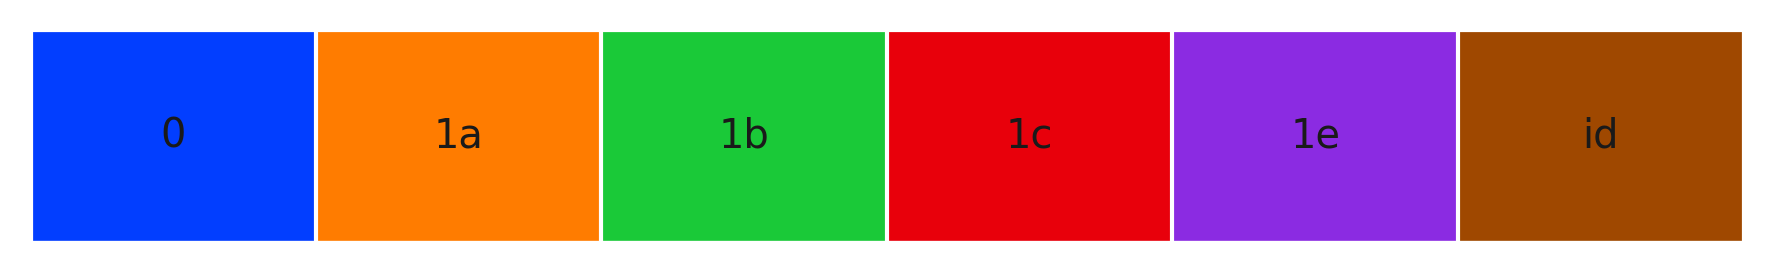

In [48]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Text(0.5, 24.066666666666585, '')

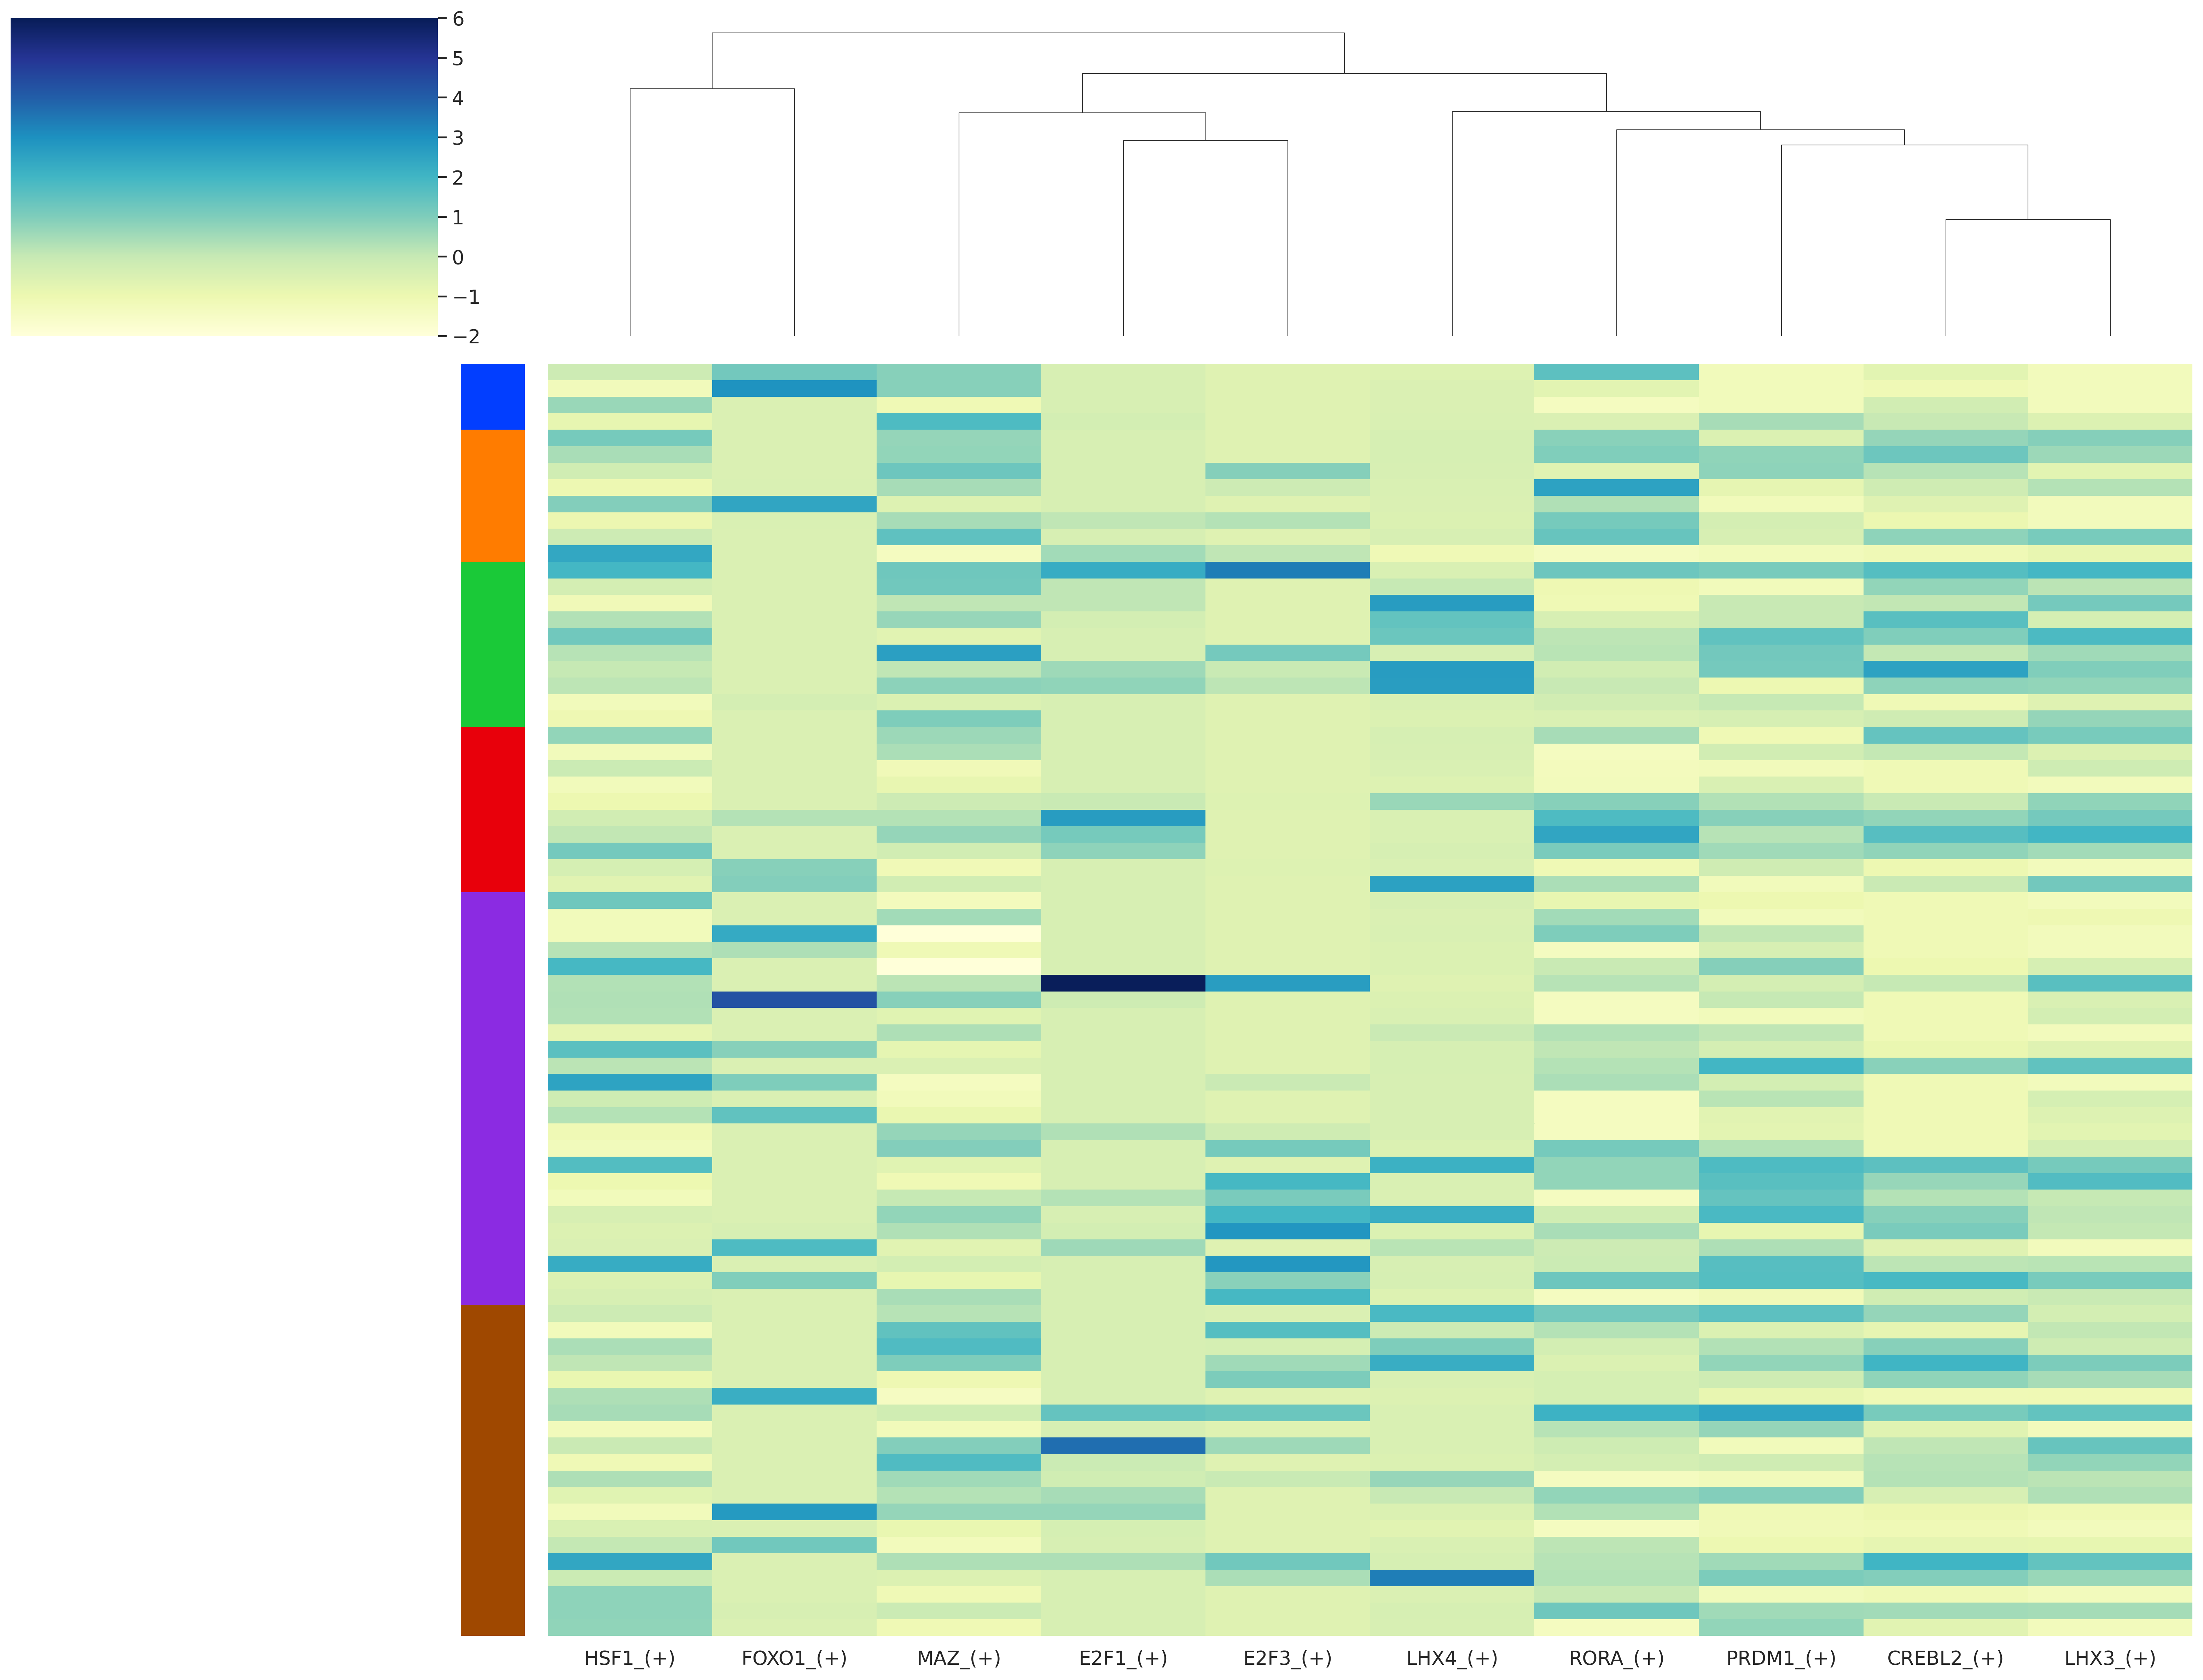

In [49]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [50]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [51]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000016


In [52]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

CREBL2_(+)  E2F1_(+)  E2F3_(+)  ESRRG_(+)  FOXO1_(+)  \
shl20171031-071           1         0         0          0          0   
shl20171031-046           0         0         0          0          0   
shl20171031-078           1         0         0          0          0   
shl20171031-057           0         0         0          0          0   
shl20171031-041           0         0         0          0          0   

                 HSF1_(+)  LHX3_(+)  LHX4_(+)  MAZ_(+)  PRDM1_(+)  RORA_(+)  \
shl20171031-071         0         1         1        0          0         0   
shl20171031-046         0         0         0        0          0         0   
shl20171031-078         0         0         0        0          0         1   
shl20171031-057         0         0         0        0          0         1   
shl20171031-041         0         0         0        0          0         1   

                 SMAD9_(+)  
shl20171031-071          0  
shl20171031-046          0  
shl20171031-078          0  
shl20171031-057          0  
shl20171031-041          0

### Show the AUC distributions for selected regulons

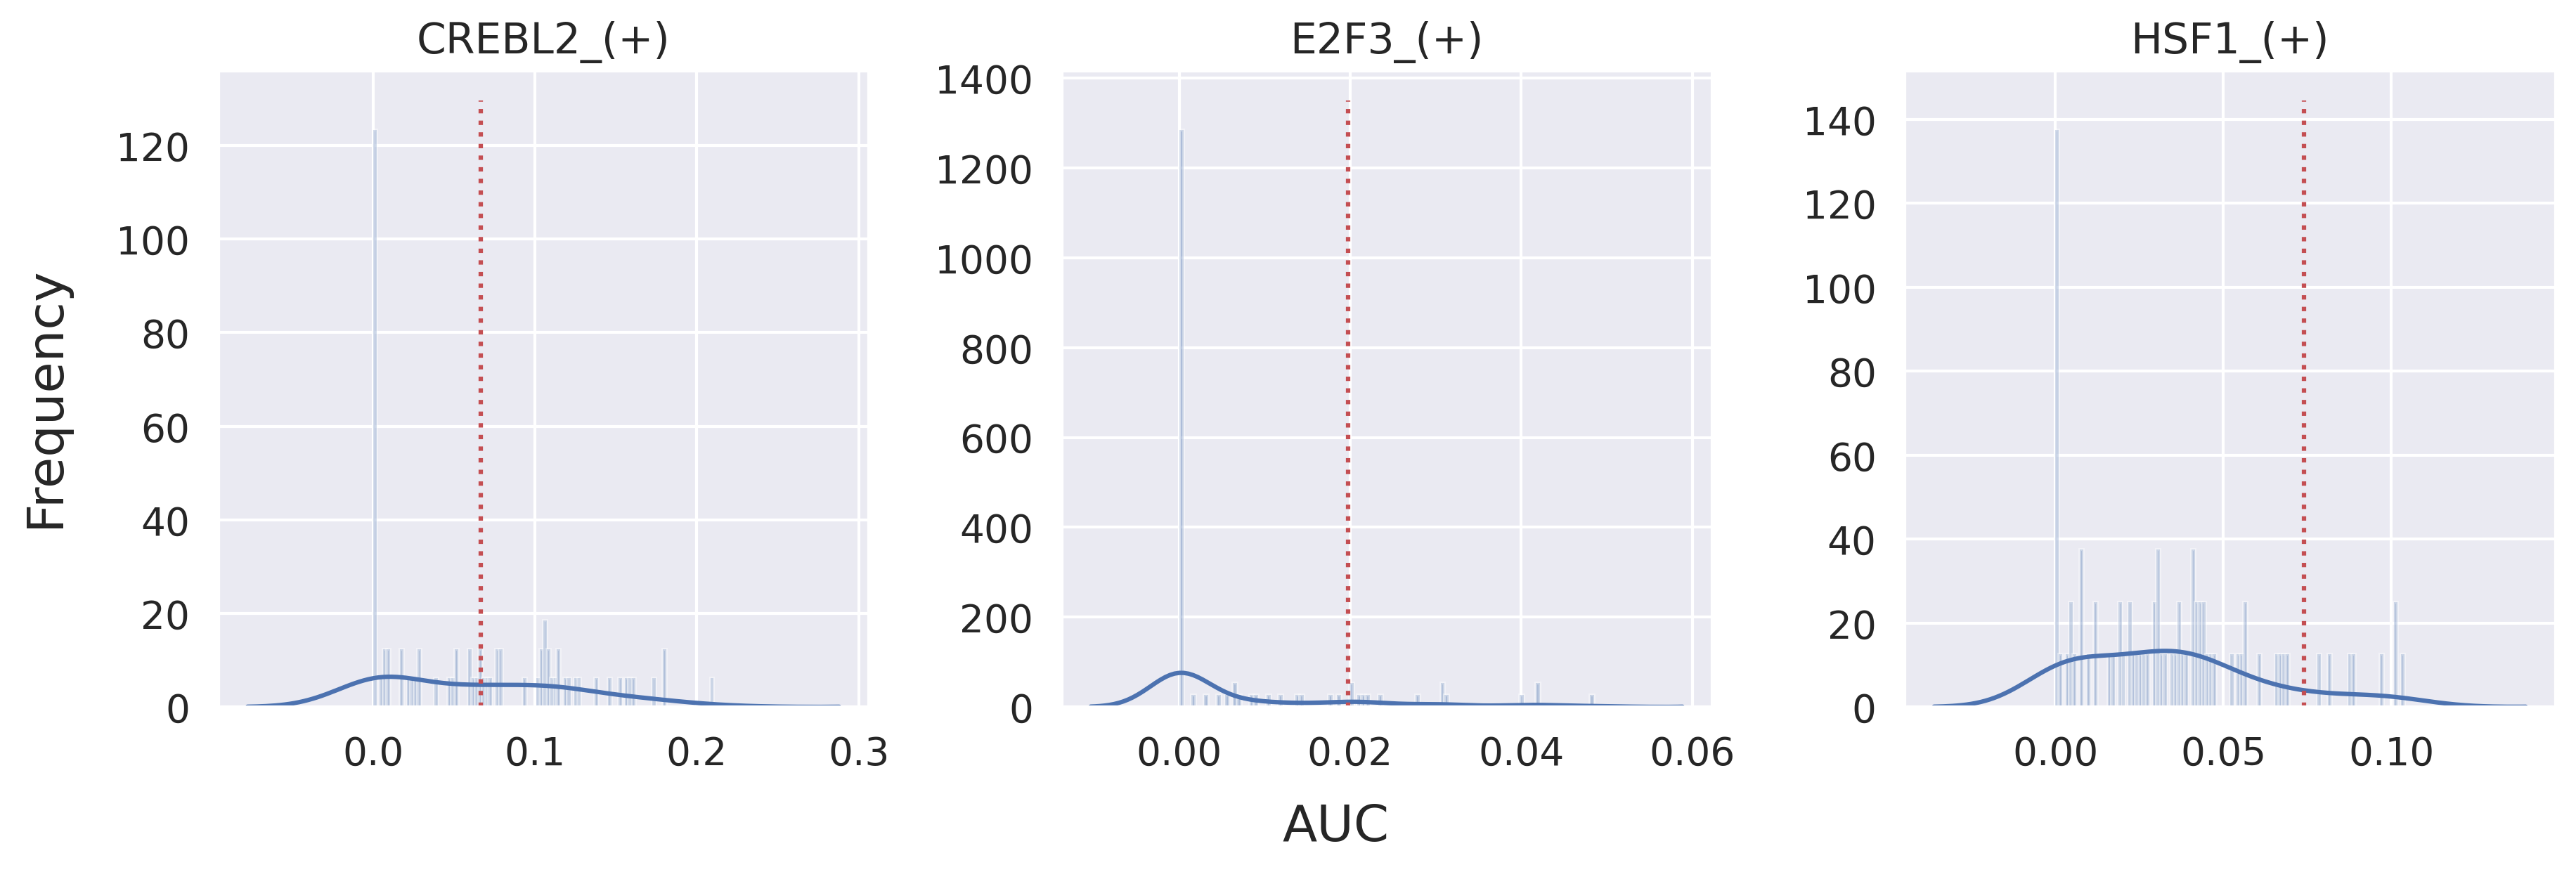

In [54]:
# select regulons:
r = [ 'CREBL2_(+)', 'E2F3_(+)', 'HSF1_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('output/scenic/scenic-binaryPlot.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [55]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [56]:
adata_h5ad.obs

nCount_RNA  nFeature_RNA     day treatment_group index_i7  \
shl20171031-041  4.647953e+06          8237   day_3           sh733     N706   
shl20171031-045  4.974402e+06          9700   day_3           sh733     N706   
shl20171031-046  3.790317e+06          8871   day_3           sh733     N706   
shl20171031-048  4.779993e+06         10950   day_3           sh733     N706   
shl20171031-049  5.192704e+06         11174   day_3           sh733     N707   
...                       ...           ...     ...             ...      ...   
shl20171031-545  4.010407e+06         11076  day_15           sh737     N710   
shl20171031-547  5.898742e+06         10019  day_15           sh737     N710   
shl20171031-548  4.751634e+06          8478  day_15           sh737     N710   
shl20171031-549  4.412243e+06         11309  day_15           sh737     N710   
shl20171031-550  4.086102e+06          7214  day_15           sh737     N710   

                 i7_bases index_i5  i5_bases  lane custom_cluster  ...  \
shl20171031-041  TAGGCATG     S502  ATAGAGAG   2.0  c1_cluster_12  ...   
shl20171031-045  TAGGCATG     S507  TACTCCTT   2.0             c3  ...   
shl20171031-046  TAGGCATG     S508  AGGCTTAG   2.0  c1_cluster_11  ...   
shl20171031-048  TAGGCATG     S511  CGGAGAGA   2.0  c1_cluster_12  ...   
shl20171031-049  CTCTCTAC     S502  ATAGAGAG   2.0  c1_cluster_12  ...   
...                   ...      ...       ...   ...            ...  ...   
shl20171031-545  CGAGGCTG     S516  ACTCTAGG   6.0             c5  ...   
shl20171031-547  CGAGGCTG     S518  CTTAATAG   6.0             c5  ...   
shl20171031-548  CGAGGCTG     S520  ATAGCCTT   6.0             c5  ...   
shl20171031-549  CGAGGCTG     S521  TAAGGCTC   6.0             c5  ...   
shl20171031-550  CGAGGCTG     S522  TCGCATAA   6.0             c5  ...   

                 E2F3_(+) ESRRG_(+) FOXO1_(+)  HSF1_(+)  LHX3_(+)  LHX4_(+)  \
shl20171031-041  0.000000  0.000000  0.022017  0.030679  0.000000  0.137891   
shl20171031-045  0.000000  0.000000  0.044843  0.000040  0.000000  0.139854   
shl20171031-046  0.000000  0.000000  0.000000  0.052385  0.000101  0.140201   
shl20171031-048  0.000000  0.000000  0.000000  0.011641  0.033650  0.141125   
shl20171031-049  0.000000  0.000000  0.000000  0.065966  0.100546  0.142280   
...                   ...       ...       ...       ...       ...       ...   
shl20171031-545  0.022173  0.000000  0.000000  0.101253  0.125455  0.142511   
shl20171031-547  0.011953  0.000000  0.000000  0.030962  0.087965  0.241483   
shl20171031-548  0.000000  0.000000  0.000000  0.056225  0.000000  0.140432   
shl20171031-549  0.000000  0.000000  0.000808  0.056710  0.080285  0.142626   
shl20171031-550  0.000000  0.152142  0.000000  0.055497  0.000000  0.141818   

                  MAZ_(+) PRDM1_(+)  RORA_(+) SMAD9_(+)  
shl20171031-041  0.203131  0.000000  0.172918       0.0  
shl20171031-045  0.202175  0.000000  0.037753       0.0  
shl20171031-046  0.084221  0.000000  0.000000       0.0  
shl20171031-048  0.256853  0.113884  0.051819       0.0  
shl20171031-049  0.190784  0.048302  0.131528       0.0  
...                   ...       ...       ...       ...  
shl20171031-545  0.171676  0.118836  0.093533       0.0  
shl20171031-547  0.117146  0.153193  0.097009       0.0  
shl20171031-548  0.082311  0.000000  0.080194       0.0  
shl20171031-549  0.143309  0.118836  0.155942       0.0  
shl20171031-550  0.084589  0.132983  0.000000       0.0  

[77 rows x 58 columns]

In [57]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

In [68]:
adata_pca = pd.read_csv("output/scenic/martin_pc_output.csv", index_col = 0)
adata_pca.index

Index(['shl20171031-108', 'shl20171031-109', 'shl20171031-110',
       'shl20171031-111', 'shl20171031-112', 'shl20171031-113',
       'shl20171031-114', 'shl20171031-115', 'shl20171031-116',
       'shl20171031-117',
       ...
       'shl20171031-073', 'shl20171031-074', 'shl20171031-075',
       'shl20171031-076', 'shl20171031-077', 'shl20171031-078',
       'shl20171031-079', 'shl20171031-082', 'shl20171031-083',
       'shl20171031-085'],
      dtype='object', length=260)

In [69]:
adata_pca
myindex

Index(['shl20171031-041', 'shl20171031-045', 'shl20171031-046',
       'shl20171031-048', 'shl20171031-049', 'shl20171031-052',
       'shl20171031-053', 'shl20171031-057', 'shl20171031-059',
       'shl20171031-061', 'shl20171031-062', 'shl20171031-063',
       'shl20171031-068', 'shl20171031-070', 'shl20171031-071',
       'shl20171031-078', 'shl20171031-079', 'shl20171031-133',
       'shl20171031-156', 'shl20171031-173', 'shl20171031-229',
       'shl20171031-234', 'shl20171031-245', 'shl20171031-250',
       'shl20171031-252', 'shl20171031-262', 'shl20171031-263',
       'shl20171031-268', 'shl20171031-318', 'shl20171031-323',
       'shl20171031-330', 'shl20171031-331', 'shl20171031-341',
       'shl20171031-349', 'shl20171031-350', 'shl20171031-354',
       'shl20171031-359', 'shl20171031-411', 'shl20171031-414',
       'shl20171031-415', 'shl20171031-416', 'shl20171031-419',
       'shl20171031-421', 'shl20171031-427', 'shl20171031-428',
       'shl20171031-431', 'shl20171031-4

In [70]:
myindex = adata_h5ad.obs.index
adata_pca0 = adata_pca.loc[myindex,]
adata_pca = adata_pca0.to_numpy()

In [71]:
# pd.DataFrame(adata_h5ad.obsm['X_pca']).shape
adata_h5ad.obsm['X_pca'][:,:20] = adata_pca

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


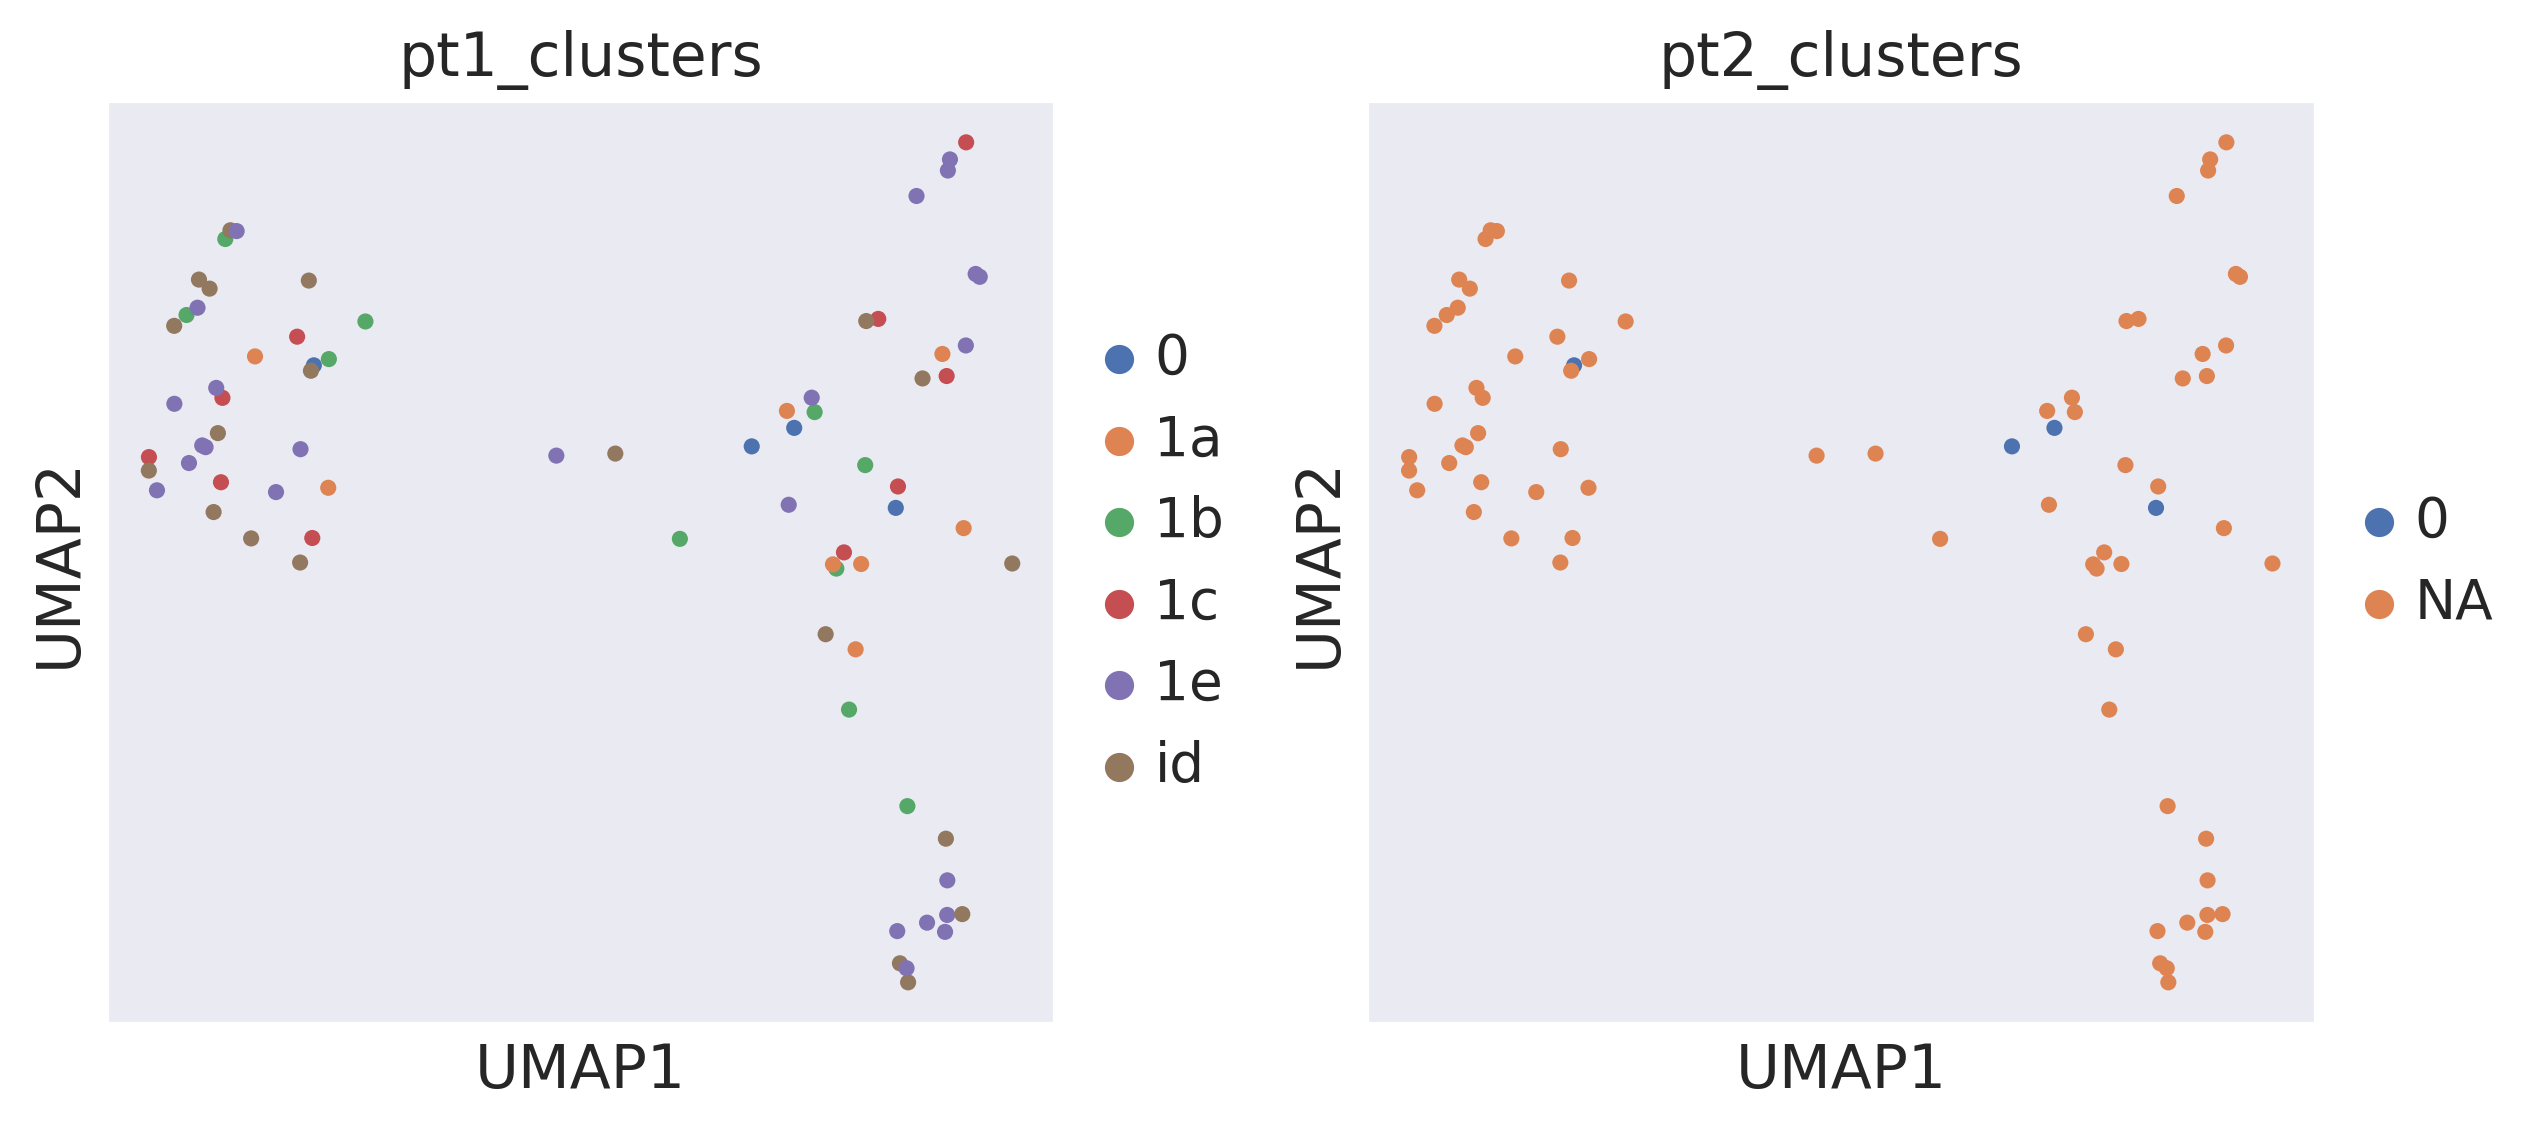

In [72]:
adata_h5ad.obs.columns
sc.pl.umap(adata_h5ad, color=['pt1_clusters', 'pt2_clusters'], size=60, save='.pdf')

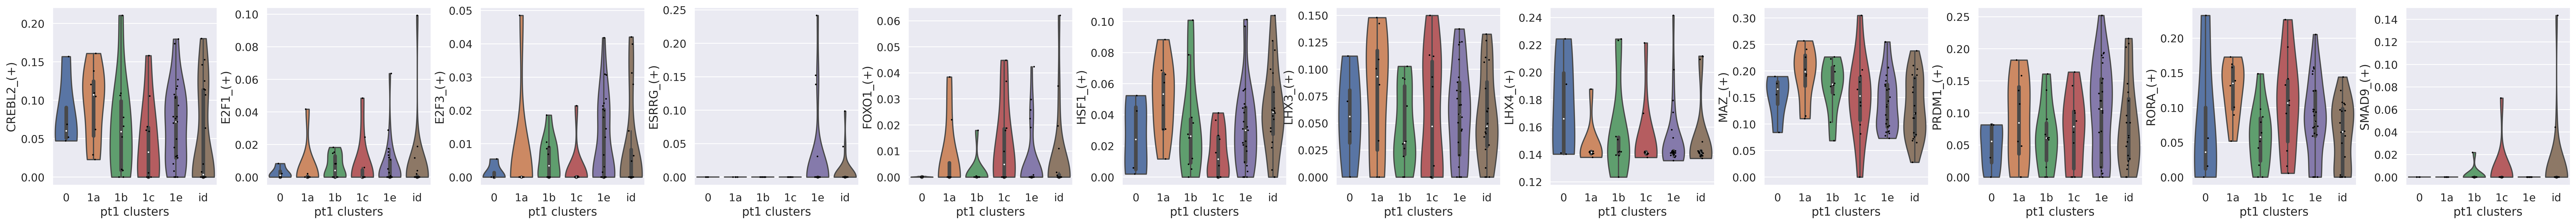

In [73]:
adata_h5ad.obs.pt1_clusters

sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt1_clusters", log=False, stripplot=True, size = 2, inner = "box")

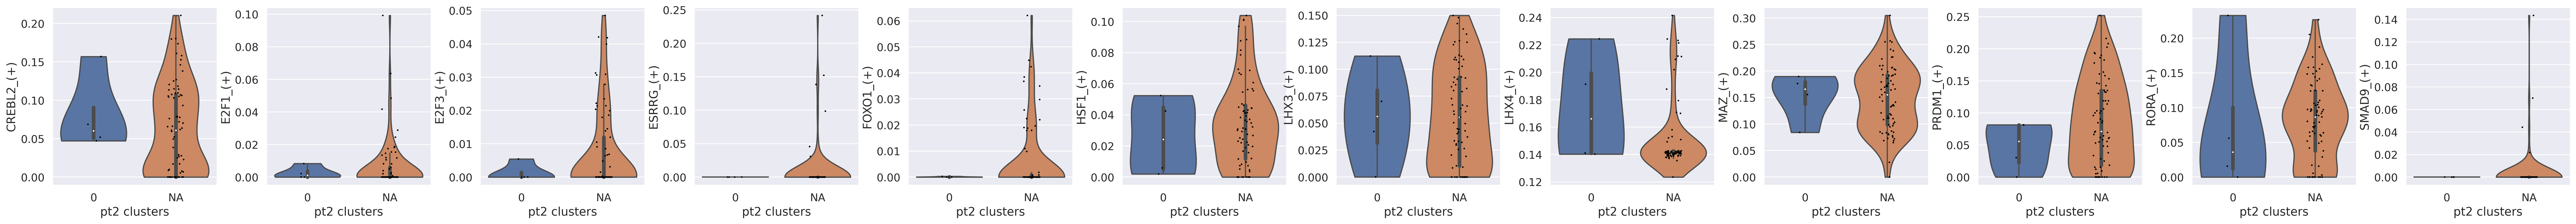

In [74]:
sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt2_clusters", log=False, stripplot=True, size = 2, inner = "box")

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


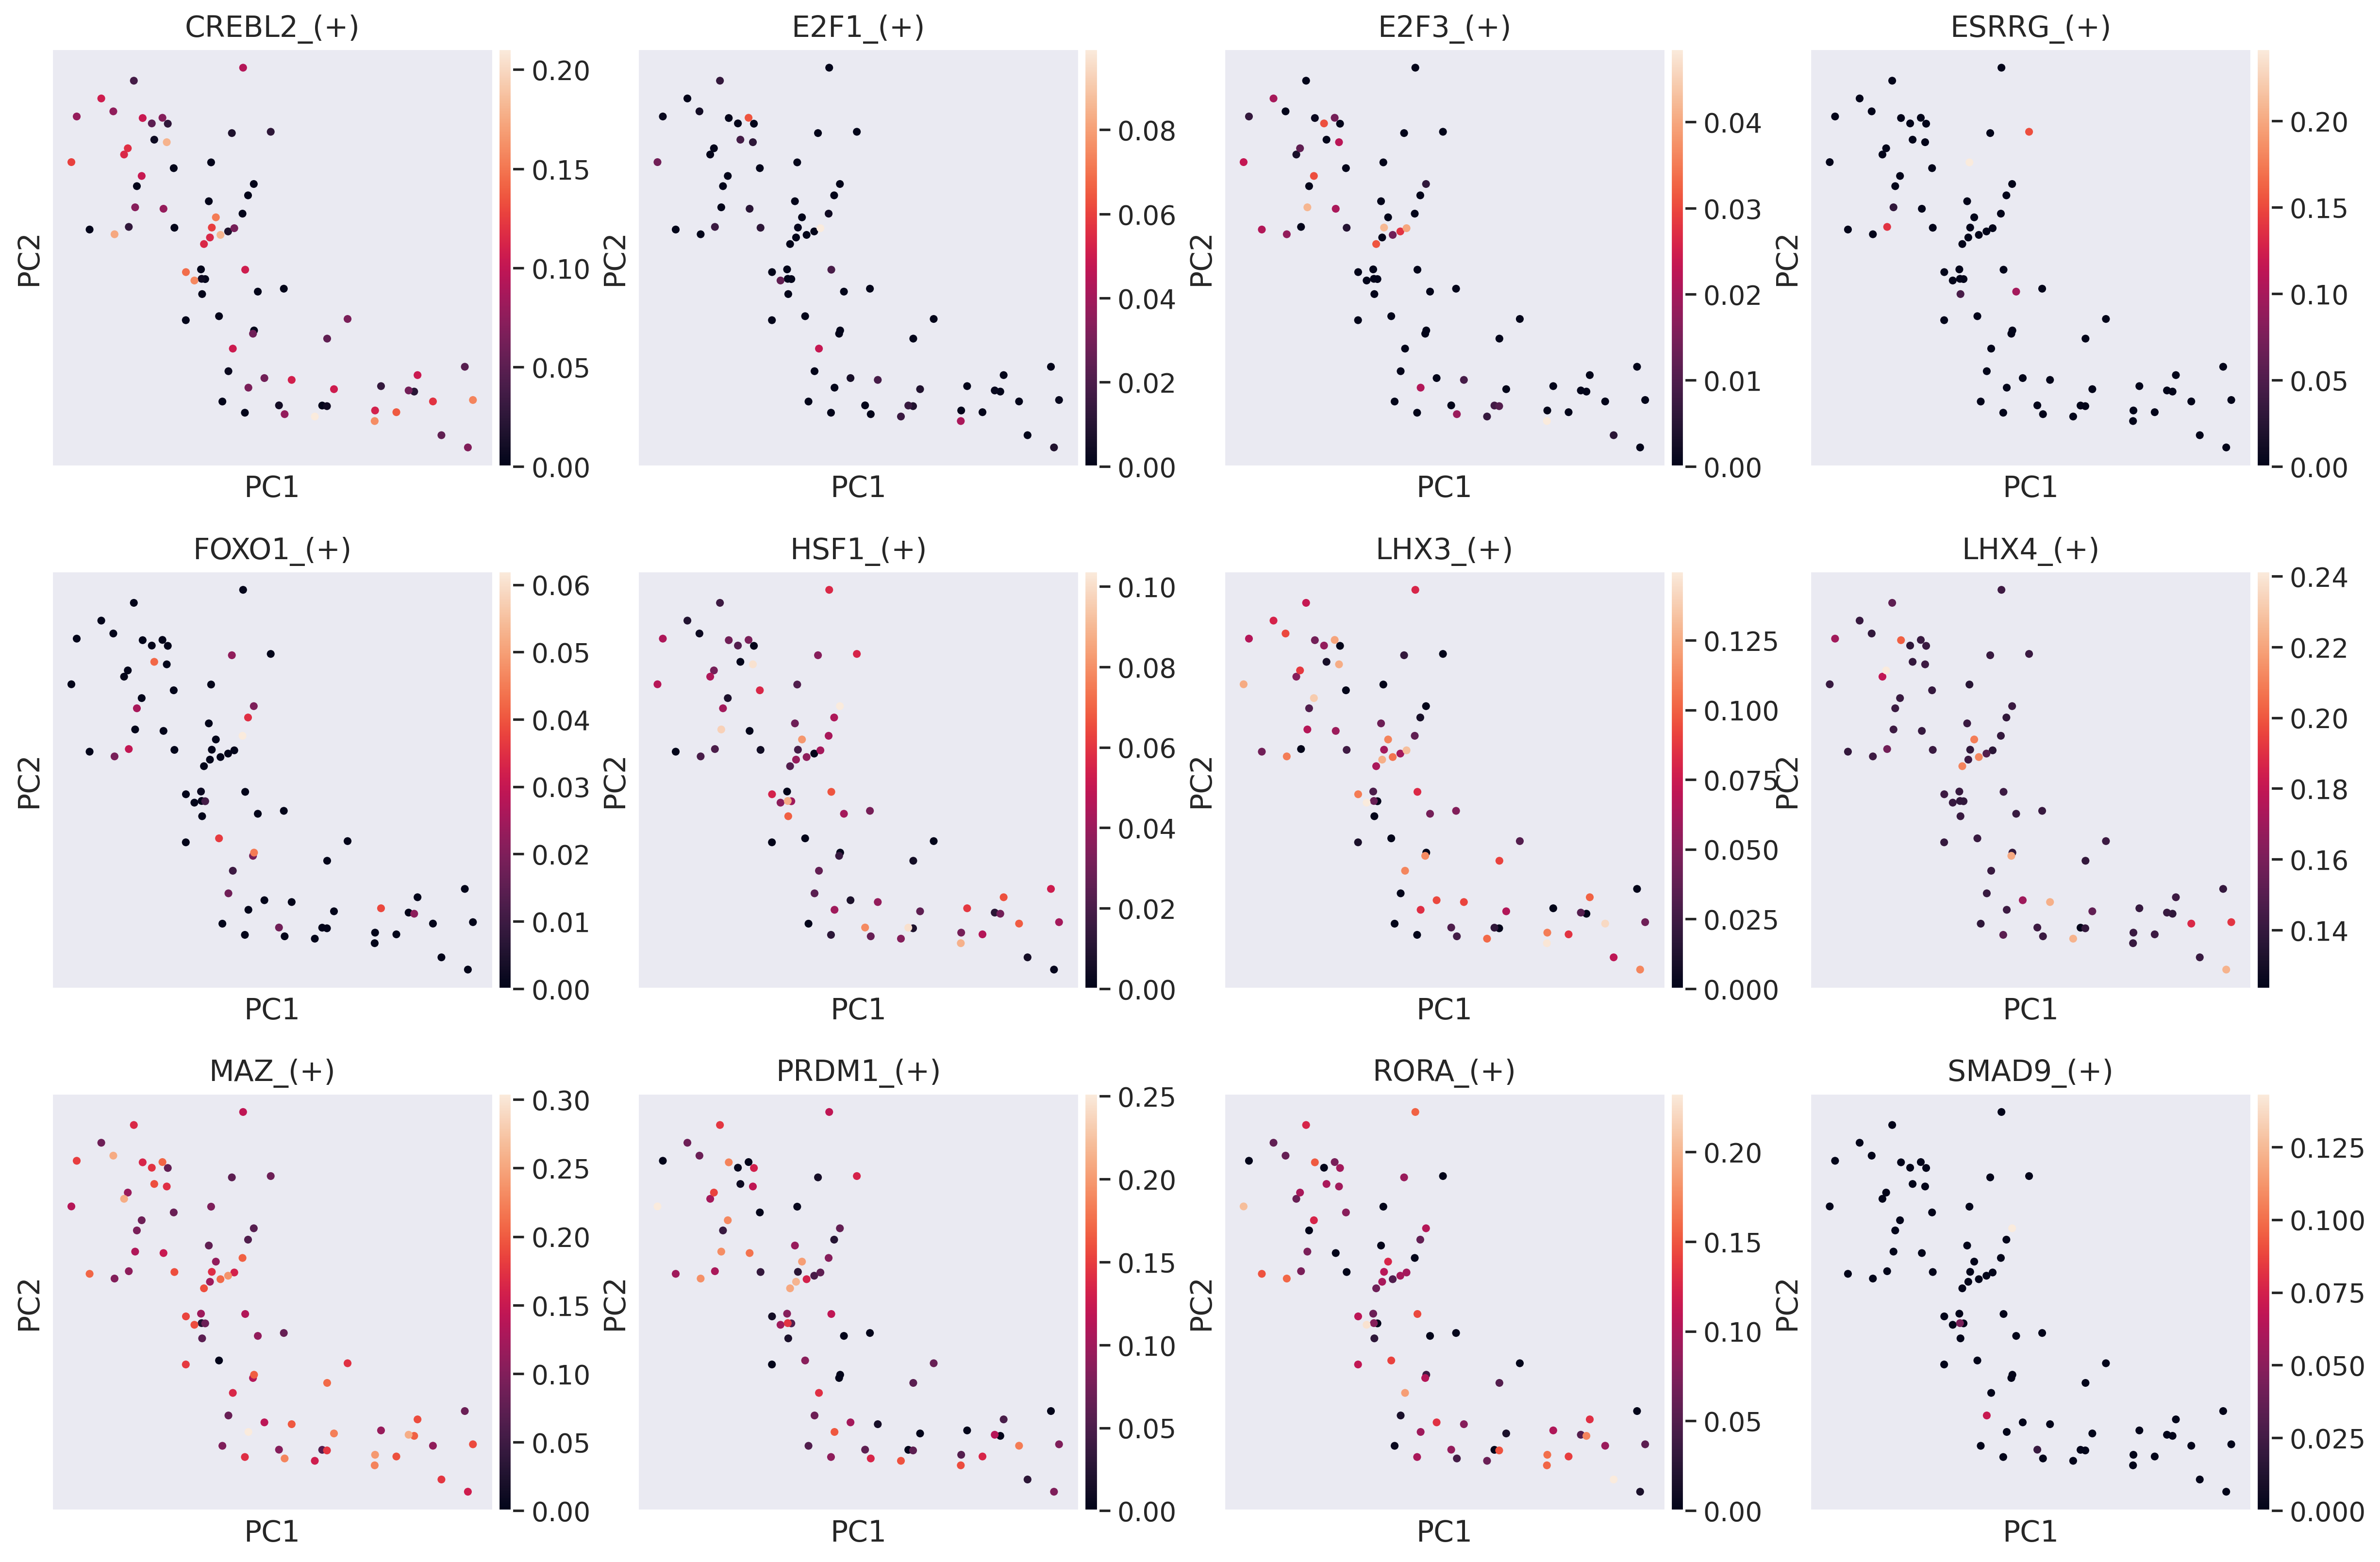

In [75]:
sc.pl.pca(adata_h5ad, components = ['1,2'], color=auc_mtx.columns, size=60, save='.pdf')

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


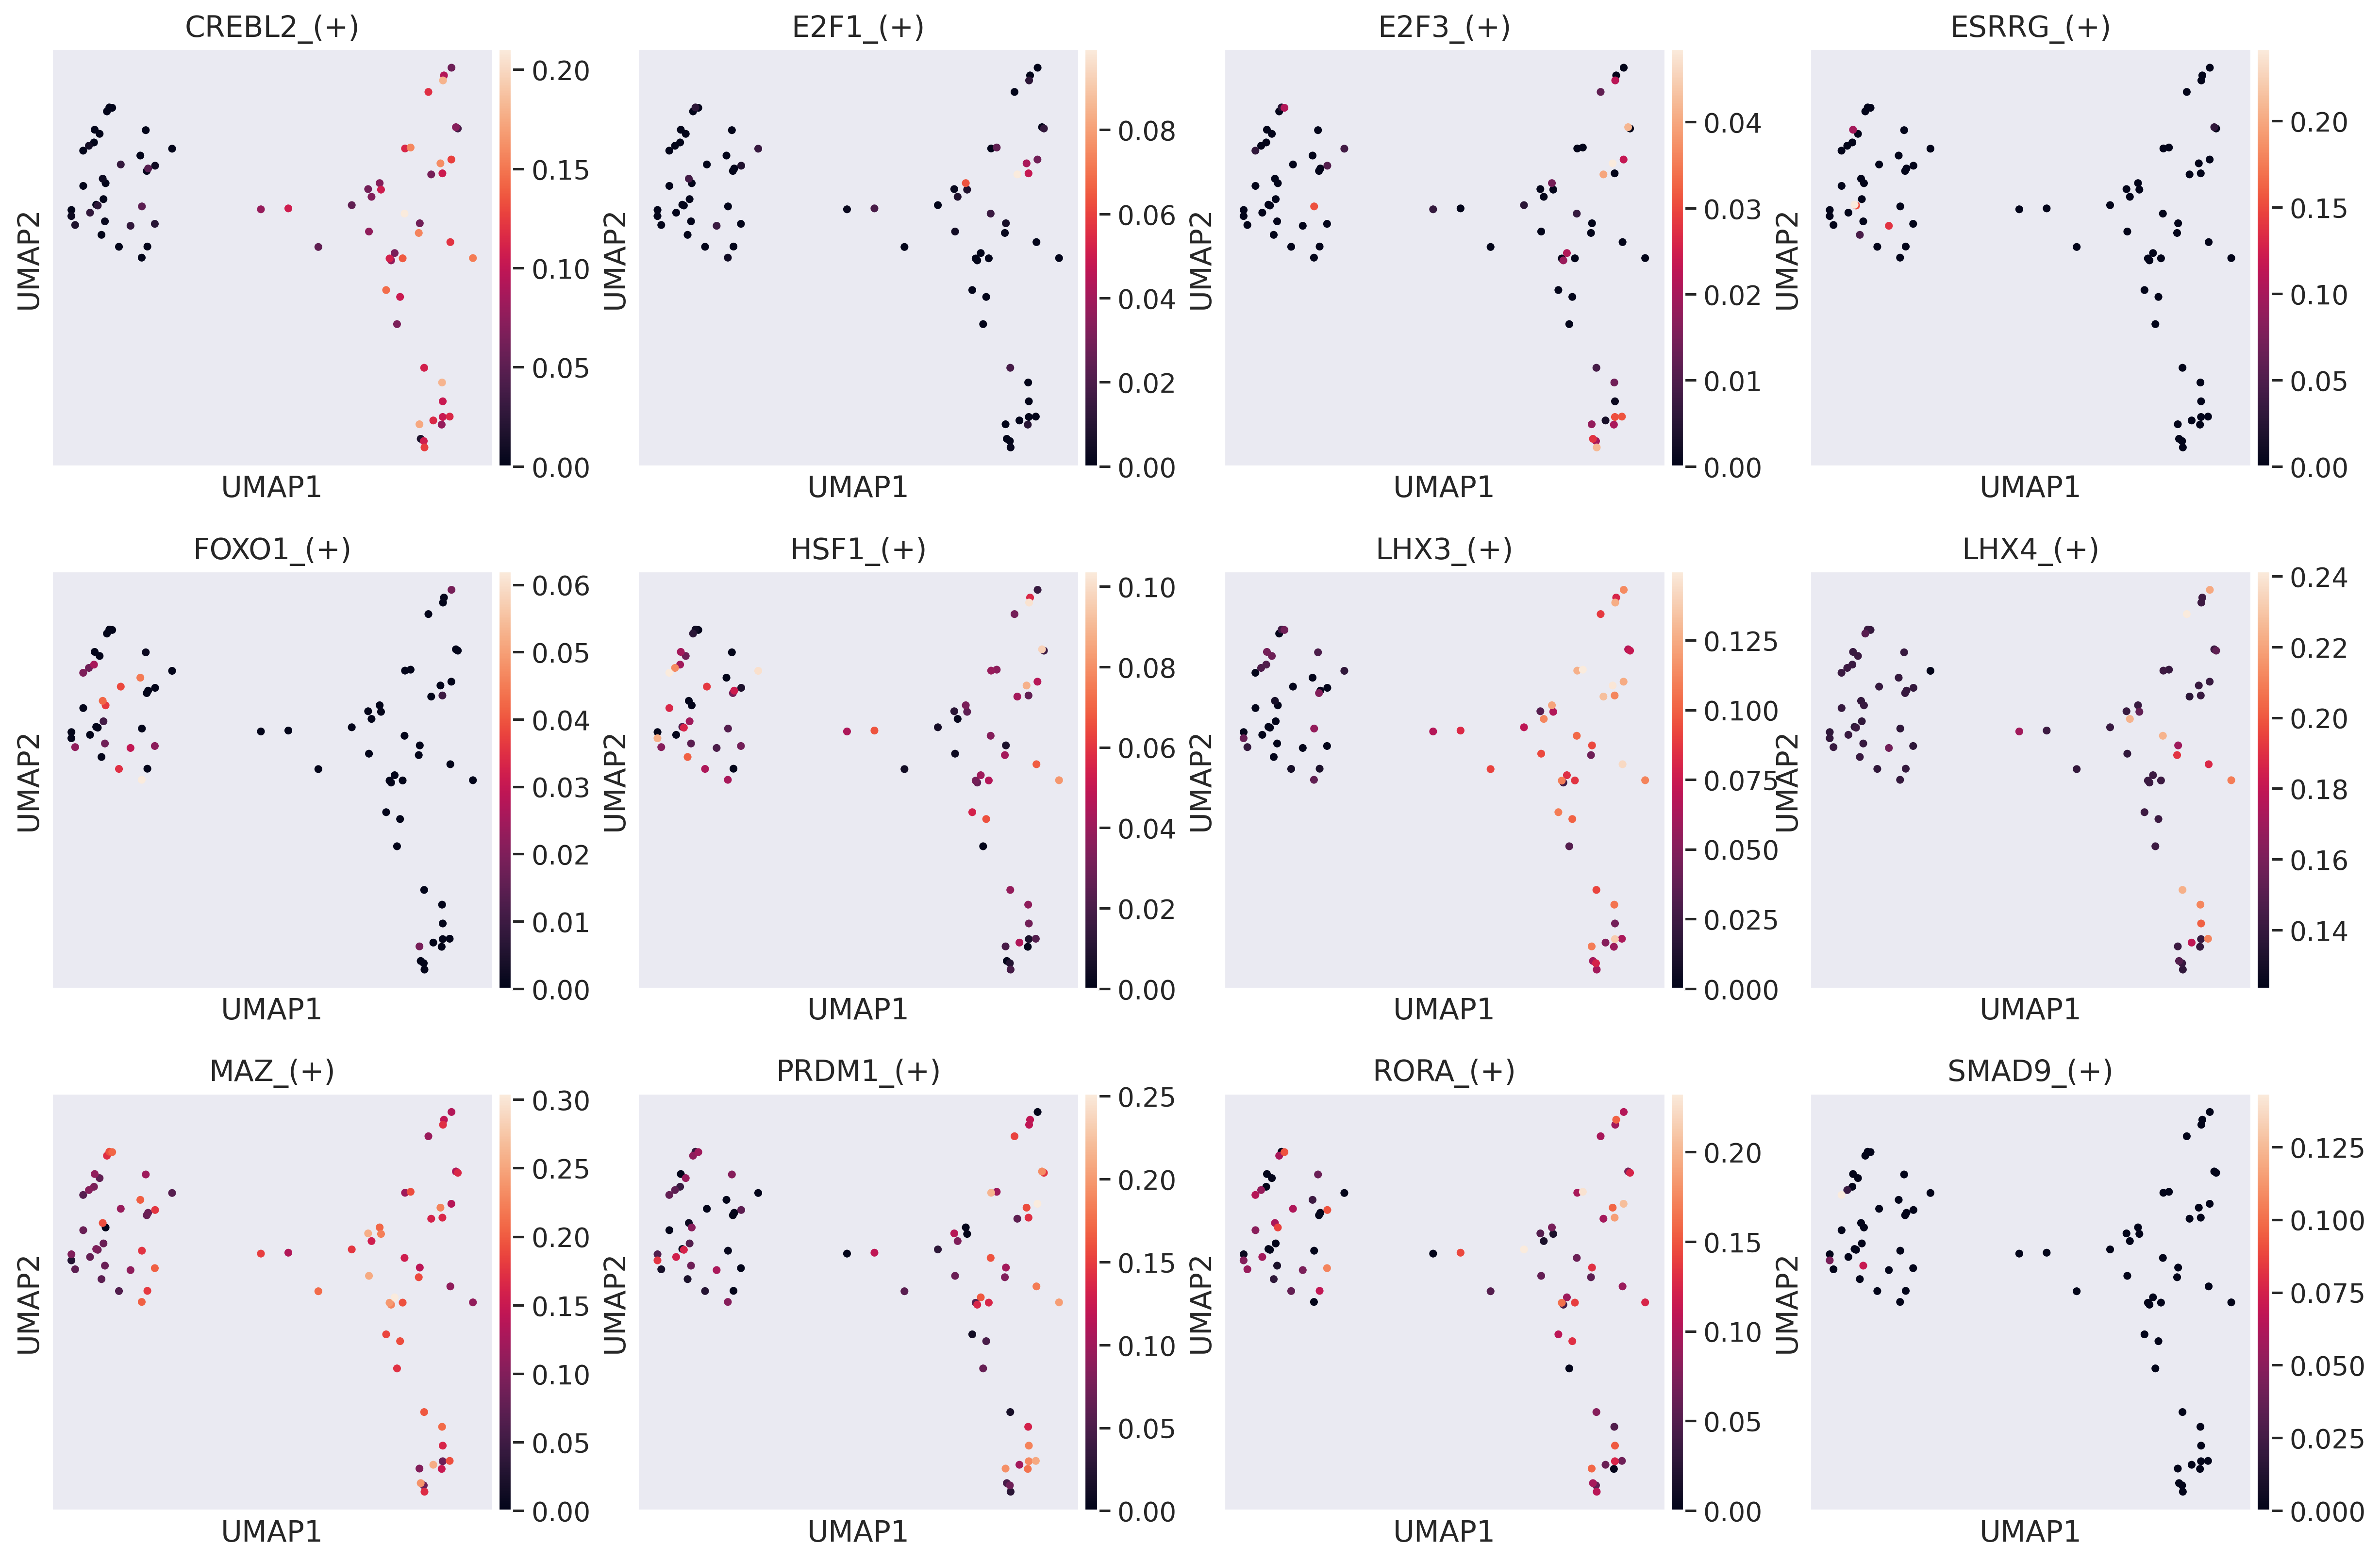

In [76]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')